In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contraction import CONTRACTION_MAP
import unicodedata

In [2]:
transcript = pd.read_csv('transcripts.csv')
ted = pd.read_csv('ted_main.csv')
ted_new = ted[['main_speaker','related_talks','tags','title','url']]
data = pd.merge(transcript,ted_new,on='url')

In [3]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [4]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [5]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [6]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)
    return text

In [7]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [8]:
transcript['transcript_clean'] = transcript.transcript.apply(remove_accented_chars)
transcript['transcript_clean'] = transcript.transcript_clean.apply(expand_contractions)


In [9]:
transcript['transcript_clean'] = transcript.transcript_clean.apply(remove_special_characters)

In [10]:
def remove_whitespace(x):
    try:
        # remove spaces inside and outside of string
        x = " ".join(x.split())

    except:
        pass
    return x

In [11]:
transcript['transcript_clean'] = transcript.transcript_clean.apply(remove_whitespace)

In [12]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')


In [135]:
from sklearn.feature_extraction import text
    #Text=transcript['transcript_clean'].tolist()

#tfidf=text.TfidfVectorizer(input=Text,stop_words=stopword_list)
#vocab = tfidf.get_feature_names()
#matrix=tfidf.fit_transform(Text)
#print(matrix.shape)


from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(Text)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)



,00,000,0000,000000004,0000001,000001,00001,000042,0001,0009,...,zx80,zx81,zyberk,zygomatic,zygotes,zynga,zyprexa,zywiec,zz143,zzzzzt
0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
from sklearn.metrics.pairwise import cosine_similarity
similar =cosine_similarity(matrix)
similar_df = pd.DataFrame(similar)

In [86]:
similar_test = similar

In [87]:
similar_test[similar_test < 0.2] = 0

In [89]:
similar_test_df = pd.DataFrame(similar_test)
#similar_df
similar_test_df

,0,1,2,3,4,5,6,7,8,9,...,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466
0,1.000000,0.000000,0.223554,0.000000,0.0,0.272419,0.262102,0.0,0.222081,0.238246,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000000,1.000000,0.000000,0.000000,0.0,0.203011,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.223554,0.000000,1.000000,0.000000,0.0,0.231836,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.272419,0.203011,0.231836,0.000000,0.0,1.000000,0.227032,0.0,0.231231,0.305366,...,0.0,0.000000,0.0,0.206015,0.0,0.0,0.0,0.0,0.212464,0.0
6,0.262102,0.000000,0.000000,0.000000,0.0,0.227032,1.000000,0.0,0.000000,0.253754,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
8,0.222081,0.000000,0.000000,0.000000,0.0,0.231231,0.000000,0.0,1.000000,0.278934,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
9,0.238246,0.000000,0.000000,0.000000,0.0,0.305366,0.253754,0.0,0.278934,1.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [118]:
similar

array([[1.        , 0.        , 0.22355372, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.22355372, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [15]:
def get_similar_articles(x):
    return ",".join(data['title'].loc[x.argsort()[-5:-1]])
data['similar_talks']=[get_similar_articles(x) for x in similar]


In [16]:
data.head(5)

,transcript,url,main_speaker,related_talks,tags,title,similar_talks
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,Ken Robinson,"[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...","['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,"A one-man world summit,How to run a company wi..."
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,Al Gore,"[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...","['alternative energy', 'cars', 'climate change...",Averting the climate crisis,"Design and discovery,A one-man world summit,A ..."
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,David Pogue,"[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...","['computers', 'entertainment', 'interface desi...",Simplicity sells,"A one-man world summit,Nerdcore comedy,Cool tr..."
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,Majora Carter,"[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...","['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,How students of color confront impostor syndro...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,Hans Rosling,"[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...","['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,"Religions and babies,The good news of the deca..."


In [69]:
similar

array([[1.        , 0.18088781, 0.22355372, ..., 0.0869772 , 0.18185134,
        0.08940881],
       [0.18088781, 1.        , 0.1903556 , ..., 0.04531078, 0.13724981,
        0.0761631 ],
       [0.22355372, 0.1903556 , 1.        , ..., 0.07486807, 0.1862775 ,
        0.08542047],
       ...,
       [0.0869772 , 0.04531078, 0.07486807, ..., 1.        , 0.06658672,
        0.05362273],
       [0.18185134, 0.13724981, 0.1862775 , ..., 0.06658672, 1.        ,
        0.09306936],
       [0.08940881, 0.0761631 , 0.08542047, ..., 0.05362273, 0.09306936,
        1.        ]])

In [17]:
data['similar_talks'][12]

"HIV and flu -- the vaccine strategy,Lessons from the 1918 flu,How we'll stop polio for good,The case for optimism"

In [138]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=2, max_iter=100, random_state=42)
dt_matrix = lda.fit_transform(tv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2'])


C:\Users\Sivakumar\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\Sivakumar\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [139]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()
    
    
    
    
    
    from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)

#topics = lda.fit_transform(matrix)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [tfidf.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

[('il', 0.7873716347207685), ('je', 0.7460158463374045), ('vie', 0.7055595200271991), ('moi', 0.6941976904197916), ('dans', 0.692245951023636), ('des', 0.6846269956115476), ('rachelle', 0.6485085019403556), ('mon', 0.6485085019399416), ('lui', 0.6485085019368673), ('mots', 0.6485085019339596), ('garniez', 0.6485085019338176), ('dit', 0.6406844414568855), ('coeur', 0.6192038035594816), ('et', 0.6053460760808075)]

[('the', 799.1679007632771), ('and', 584.5967295784371), ('to', 501.1607720656791), ('of', 446.5875663897371), ('is', 406.14469383668177), ('that', 366.0760750740596), ('in', 306.3083096505214), ('it', 286.1073939567411), ('you', 271.95126555229604), ('we', 269.99553659203735), ('this', 188.5593705694987), ('are', 178.1925786780192), ('not', 153.8695983022678), ('have', 144.0535058826093), ('so', 143.57488679205278), ('was', 132.9872314091005), ('they', 129.89512751912298), ('for', 123.41161916581673), ('but', 109.32194542142851), ('what', 105.28887144128805), ('on', 103.79902

AttributeError: 'LatentDirichletAllocation' object has no attribute 'components_'

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)

topics = lda.fit_transform(matrix)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [tfidf.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

C:\Users\Sivakumar\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


{0: ['wikipedia', 'not', 'images', 'page', 'notre'],
 1: ['mockingbird', 'mockingbirds', 'juanito', 'mimus', 'vente'],
 2: ['not', 'one', 'want', 'people', 'cannot'],
 3: ['molas', 'mola', 'not', 'laughter', 'think'],
 4: ['wk', 'kasungu', 'mala', 'kamkwamba', 'da'],
 5: ['clonie', 'eminem', 'spector', 'ie', 'huggable'],
 6: ['not', 'people', 'one', 'like', 'would'],
 7: ['not', 'like', 'one', 'laughter', 'people'],
 8: ['halter', 'vie', 'lui', 'mots', 'rachelle'],
 9: ['kiteflyers', 'hewerdine', 'not', 'music', 'would']}

In [19]:
from sklearn.decomposition import NMF

n_topics = 10
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(matrix)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [tfidf.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

{0: ['not', 'laughter', 'know', 'people', 'like'],
 1: ['data', 'actually', 'computer', 'like', 'information'],
 2: ['music', 'applause', 'sound', 'guitar', 'play'],
 3: ['not', 'people', 'world', 'countries', 'africa'],
 4: ['cancer', 'cells', 'patients', 'disease', 'cell'],
 5: ['water', 'earth', 'planet', 'ocean', 'universe'],
 6: ['women', 'men', 'girls', 'not', 'woman'],
 7: ['city', 'cities', 'building', 'design', 'buildings'],
 8: ['brain', 'neurons', 'brains', 'cells', 'human'],
 9: ['kids', 'school', 'children', 'education', 'students']}

In [20]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', tfidf),
    ('nmf', nmf)
])

document_id = 6
t = pipe.transform([transcript['transcript_clean'].iloc[document_id]]) 
print('Topic distribution for document #{}: \n'.format(document_id),t)
print('Relevant topics for document #{}: \n'.format(document_id),np.where(t>0.01)[1])
print('\nTranscript:\n',transcript['transcript_clean'].iloc[document_id][:500],'...')

talk = ted[ted['url']==transcript['url'].iloc[document_id]]

#talk = data[data['url'].iloc[document_id]]
print('\nTrue tags from ted_main.csv: \n',talk['tags'])

Topic distribution for document #6: 
 [[0.11322825 0.         0.         0.         0.         0.
  0.038167   0.         0.         0.02529564]]
Relevant topics for document #6: 
 [0 6 9]

Transcript:
 On September 10 the morning of my seventh birthday I came downstairs to the kitchen where my mother was washing the dishes and my father was reading the paper or something and I sort of presented myself to them in the doorway and they said Hey happy birthday And I said I am seven And my father smiled and said Well you know what that means do not you And I said Yeah that I am going to have a party and a cake and get a lot of presents And my dad said Well yes But more importantly being seven means ...

True tags from ted_main.csv: 
 6    ['Christianity', 'God', 'atheism', 'comedy', '...
Name: tags, dtype: object


In [123]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similar_test, 'ward',metric='euclidean')
z_df = pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')

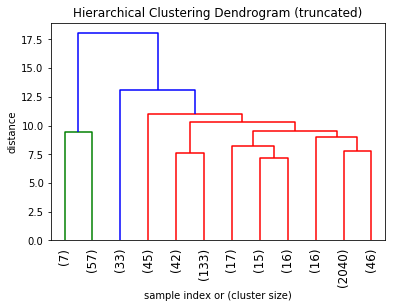

In [91]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    #show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [124]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(similar_test))
c

0.7650138968451495

In [ ]:
Z[1]

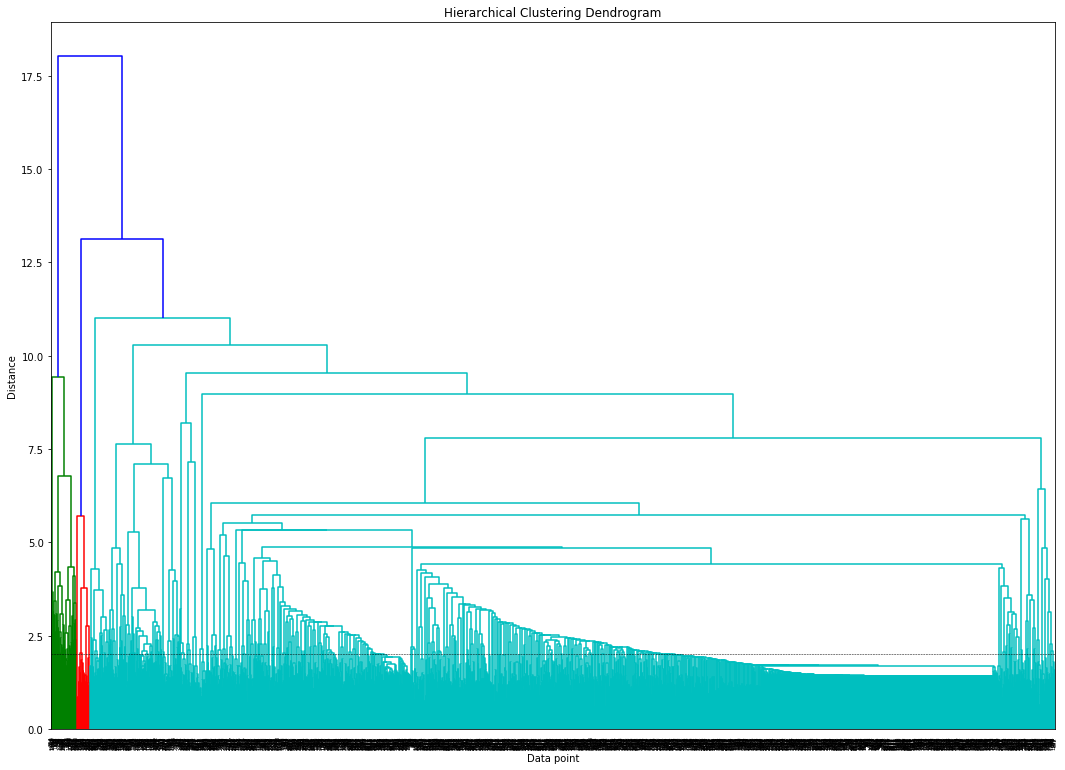

In [92]:

import matplotlib.pyplot as plt


plt.figure(figsize=(18, 13))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=2.0, c='k', ls='--', lw=0.5)

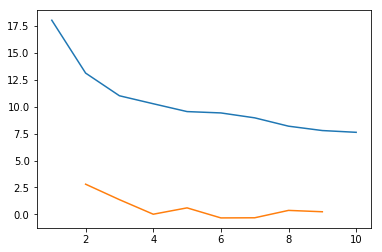

clusters: 2


In [125]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

In [126]:
from scipy.cluster.hierarchy import fcluster
labels = fcluster(Z,4,criterion='distance')

In [127]:
labels



array([ 6, 30, 15, ..., 22, 34, 24], dtype=int32)

In [128]:
test = pd.DataFrame({'labels':labels,'talk':data.title})

In [129]:
test.sort_values('labels')

,labels,talk
1419,1,Our failing schools. Enough is enough!
1967,1,How to find work you love
1832,1,How to run a company with (almost) no rules
5,1,Why we do what we do
364,1,Design and discovery
634,1,The danger of science denial
354,1,Play! Experiment! Discover!
39,2,My wish: Three actions for Africa
100,2,The genesis of Google
143,2,10 ways the world could end


In [9]:
test[test['labels'] == 47]

NameError: name 'test' is not defined

In [46]:
test.columns

Index(['labels', 'talk'], dtype='object')

In [8]:
from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

#if opts.minibatch:
   # km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                   #      init_size=1000, batch_size=1000)
#else:
km = KMeans(n_clusters=8, init='k-means++', max_iter=100, n_init=1,)               
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(t)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


#if not opts.use_hashing:
print("Top terms per cluster:")

    #if opts.n_components:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
    #else:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=8, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


NameError: name 't' is not defined